# Importing Libraries and Data

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [319]:
weather = pd.read_csv('./weather_data', index_col=0)
trap = pd.read_csv('./mosquito_data', index_col=0)
test = pd.read_csv('./test_data', index_col=0)
yearly_weather = pd.read_csv('./yearly_weather_data')

In [320]:
# Converting the dates back into datetime 
weather.index = pd.DatetimeIndex(weather.index)
trap['Date'] = pd.to_datetime(trap['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Chunking the Data
### Grouping the data into areas
#### Creating the evenly sized groups

In [321]:
# Determining the boundaries of the space
long_max = trap['Longitude'].max() 
long_min = trap['Longitude'].min()
lat_max = trap['Latitude'].max()
lat_min = trap['Latitude'].min()
long_boundaries = np.linspace(long_min, long_max + .000001, 7)
lat_boundaries = np.linspace(lat_min, lat_max + .000001, 7)

In [322]:
# Identifying the area of each trap
i = 0
for long_0, long_1 in zip(long_boundaries, long_boundaries[1:]):
    for lat_0, lat_1 in zip(lat_boundaries, lat_boundaries[1:]):
        
        i += 1
        
        for row in trap.index:
            if (long_0 <= trap.loc[row, 'Longitude'] < long_1) & (lat_0 <= trap.loc[row, 'Latitude'] < lat_1):
                trap.loc[row, 'Area'] = i
#             else:
#                 trap.loc[row, 'Area_' + str(i)] = 0      

#### Observing the areas

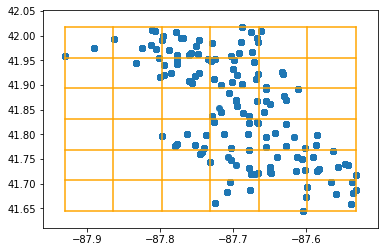

In [323]:
# Graphing to see how the areas ended up
plt.scatter(trap['Longitude'], trap['Latitude'])
for long in long_boundaries:
    plt.plot([long]*len(lat_boundaries), lat_boundaries, color='orange')
for lat in lat_boundaries:
    plt.plot(long_boundaries, [lat]*len(long_boundaries), color='orange');

#### Combining the area data

In [7]:
# Grouping and saving the trap data
# trap = trap.groupby(['Date', 'Area'], as_index=False).sum()

### Grouping into Weeks

In [ ]:
# # Grouping the trap data into weekly data
# trap = trap.groupby([pd.Grouper(key=('Date'), freq='7d'), 'Area']).sum()
# trap.reset_index(inplace=True)

In [ ]:
# # Grouping the weather data into weekly data
# weather = weather.resample('7d').mean()

# Creating Generalized Features

In [324]:
# Creating a degree week feature that measures how far above 71.6 degrees the week was
weather['DW'] = weather['Tavg'].map(lambda x: x - 71.6 if x > 71.6 else 0)

In [325]:
# Creating a rolling precipitation feature
weather['Precip_r3'] = weather['PrecipTotal'].rolling(3, min_periods=1).mean()

In [326]:
# Creating spring precipitation feature
for year in weather.index.year.unique():
    weather.loc[str(year), 'Precip_may'] = weather.loc[str(year) + '-05', 'PrecipTotal'].mean()

In [327]:
# Creating a vector index feature
Pipiens_VI = trap['Num_Pipiens'] * trap['WNV_Pipiens']
Restuans_VI = trap['Num_Restuans'] * trap['WNV_Restuans']
trap['VI'] = Pipiens_VI + Restuans_VI

In [328]:
# Creating distance weights
for row in trap.index:
    
    # Update these features for the observation
    long = trap.loc[row, 'Longitude']
    lat = trap.loc[row, 'Latitude']
    date = trap.loc[row, 'Date']
    trap.loc[row, 'Vector_Distance'] = 0
    
    for row_2 in trap[trap['Date']==date].drop(row).index:
        
        # Calculate the inverse distances with other row and multiply them by their VI
        long_dist = abs(long - trap.loc[row_2, 'Longitude'])
        lat_dist = abs(lat - trap.loc[row_2, 'Latitude'])
        distance = ((long_dist ** 2) + (lat_dist ** 2)) ** .5
        vector_distance = (1.0 / distance) * trap.loc[row_2, 'VI']
        trap.loc[row, 'Vector_Distance'] += vector_distance

In [375]:
# Adding the previous year's precipitation
for year in range(2007, 2014):
    for date in trap['Date'].unique():
        if date in pd.DatetimeIndex(start=str(year), end=str(year + 1), freq='d'):
            for row in trap[trap['Date']==date].index:
                trap.loc[row, 'Precip_last_year'] = yearly_weather[yearly_weather['DATE']==year-1]['PRCP'].values[0]

In [452]:
for year in range(2007, 2015):
    for date in test['Date'].unique():
        if date in pd.DatetimeIndex(start=str(year), end=str(year + 1), freq='d'):
            for row in test[test['Date']==date].index:
                test.loc[row, 'Precip_last_year'] = yearly_weather[yearly_weather['DATE']==year-1]['PRCP'].values[0]

# Create 1 week rolling features for many lags

In [377]:
# 1 week rolling degree weeks for the last 6 weeks
for i in range(1,6):
    weather['DW_' + str(i)] = weather['DW'].shift(i*7).rolling(7, min_periods=1).mean()
    weather['DW_' + str(i)].fillna(0, inplace=True)

In [378]:
# 1 week rolling precipitation for the last 6 weeks
for i in range(1,6):
    weather['Precip_' + str(i)] = weather['PrecipTotal'].shift(i*7).rolling(7, min_periods=1).mean()
    weather['Precip_' + str(i)].fillna(0, inplace=True)

In [379]:
# Creating a lag for the last trap data for the VI
for trap_number in trap['Trap'].unique():
    for row in trap[trap['Trap']==trap_number].index:
        trap.loc[row, 'VI_1'] = trap[trap['Trap']==trap_number]['VI'].shift(1)[row]
for row in trap[trap['VI_1'].isna()].index:
    date = trap.loc[row, 'Date']
    trap.loc[row, 'VI_1'] = trap.groupby('Date').mean().shift(1)['VI'][date]
trap['VI_1'].fillna(0, inplace=True)

In [380]:
# Creating a lag of the last trap data for the Vector Distance
for trap_number in trap['Trap'].unique():
    for row in trap[trap['Trap']==trap_number].index:
        trap.loc[row, 'Vector_Distance_1'] = trap[trap['Trap']==trap_number]['Vector_Distance'].shift(1)[row]
for row in trap[trap['Vector_Distance_1'].isna()].index:
    date = trap.loc[row, 'Date']
    trap.loc[row, 'Vector_Distance_1'] = trap.groupby('Date').mean().shift(1)['Vector_Distance'][date]
trap['Vector_Distance_1'].fillna(0, inplace=True)

In [172]:
# pd.merge(trap, trap.groupby([pd.Grouper(key='Date', freq='7d'), 'Area']).sum().reset_index()[['Date', 'VI']], left_on='Date', right_on='Date', how='left').shape

# Creating Weekly Forecast Features

In [ ]:
# Creating DW with a 3 week lag
weather['DW_l1'] = weather['DW'].shift(1)

In [ ]:
# Creating a precipitation feature with a 3 week lag
weather['Precip_r3_l1'] = weather['Precip_r3'].shift(1)

In [ ]:
# Creating a rolling 2 week VI with a 3 week lag
trap['VI_l1'] = trap['VI'].shift(1)
trap.fillna(0, inplace=True)

In [ ]:
# Creating a rolling vector distance with a 2 week lag
trap['Vector_Distance_l1'] = trap['Vector_Distance'].shift(1)
trap['Vector_Distance_l1'].fillna(0, inplace=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
trap['Vector_Distance_l1'].describe()

In [ ]:
plt.scatter(trap['Vector_Distance_l1'], trap['WnvPresent'])

In [ ]:
trap[trap['WnvPresent']==11]

In [ ]:
trap[trap['Date']=='2007-08-14']

# Creating Early Forecast Features

# Creating Post Spray Forecast Features

# Preparing Merged Data Frame

In [381]:
# Merging the data and using the date as the index
df = pd.merge(trap, weather, left_on='Date', right_on='Date', how='left')
df.set_index('Date', inplace=True)
df_test = pd.merge(test, weather, left_on='Date', right_on='Date', how='left')
df_test.set_index('Date', inplace=True)

In [382]:
# Fixing the WnvPresent column to be 1 if present and 0 if not
df['WnvPresent'] = df['WnvPresent'].map(lambda x: 1 if x >= 1 else 0)

# Basic Model

In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

##### Creating an X and y

In [408]:
model_features = ['DW_1', 'DW_2', 'DW_3', 'DW_4', 'DW_5', 'Precip_1', 'Precip_2', 'Precip_3', 'Precip_4',
                  'Precip_5', 'Precip_may', 'Longitude', 'Latitude', 'VI_1', 'Vector_Distance_1', 'Precip_last_year']
X_train = df.loc['2007':'2011', model_features]
# X_train = pd.get_dummies(X_train, columns=['Area'])
y_train = df.loc['2007':'2011', 'WnvPresent']
X_test = df.loc['2013', model_features]
# X_test = pd.get_dummies(X_test, columns=['Area'])
y_test = df.loc['2013', 'WnvPresent']

In [434]:
model_features = ['DW_1', 'DW_2', 'DW_3', 'DW_4', 'DW_5', 'Precip_1', 'Precip_2', 'Precip_3', 'Precip_4',
                  'Precip_5', 'Precip_may', 'Longitude', 'Latitude', 'Precip_last_year']
X_train, X_test, y_train, y_test = train_test_split(df[model_features], df['WnvPresent'], stratify=df['WnvPresent'])
# X_train = pd.get_dummies(X_train, columns=['Area'])
# X_test = pd.get_dummies(X_test, columns=['Area'])

In [435]:
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

In [436]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [437]:
model = AdaBoostClassifier(n_estimators=100, learning_rate=1)
cross_val_score(model, X_resampled, y_resampled, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


array([0.7955626 , 0.83122029, 0.82646593, 0.82063492, 0.81428571])

In [438]:
model.fit(X_resampled, y_resampled);

In [439]:
pd.DataFrame([model.feature_importances_], columns=X_train.columns, index=['Importance'])

,DW_1,DW_2,DW_3,DW_4,DW_5,Precip_1,Precip_2,Precip_3,Precip_4,Precip_5,Precip_may,Longitude,Latitude,Precip_last_year
Importance,0.04,0.01,0.02,0.08,0.07,0.08,0.05,0.09,0.05,0.07,0.01,0.2,0.21,0.02


In [440]:
pd.Series(model.predict(X_train)).value_counts()

0    2437
1    1005
dtype: int64

In [441]:
pd.DataFrame(model.predict(X_test))[0].value_counts()

0    812
1    336
Name: 0, dtype: int64

In [442]:
model.score(X_test, y_test), 1 - y_test.mean()

(0.7560975609756098, 0.9163763066202091)

In [443]:
y_hat = model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_hat), columns=['Predicted Negative', 'Predicted Positive'],
             index=['True Negatve', 'True Positive'])

,Predicted Negative,Predicted Positive
True Negatve,792,260
True Positive,20,76


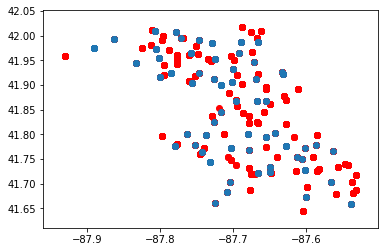

In [418]:
plt.scatter(trap['Longitude'], trap['Latitude'], color='red')
plt.scatter(X_test[y_test==1].loc['2013', 'Longitude'], X_test[y_test==1].loc['2013', 'Latitude']);

In [458]:
y_test_hat = model.predict(df_test[model_features])

In [472]:
model.predict(df_test.loc['2008', model_features]).mean()

0.15735099337748346

In [473]:
model.predict(df_test.loc['2010', model_features]).mean()

0.2507726269315673

In [474]:
model.predict(df_test.loc['2012', model_features]).mean()

0.2980132450331126

In [475]:
model.predict(df_test.loc['2014', model_features]).mean()

0.08204562178072111

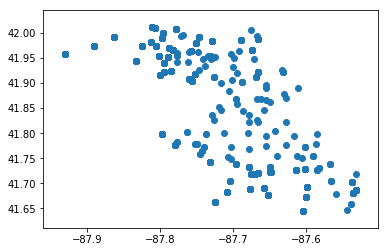

In [469]:
plt.scatter(df_test[y_test_hat==1].loc['2008', 'Longitude'], df_test[y_test_hat==1].loc['2008', 'Latitude']);

In [ ]:
plt.scatter(df['VI'], df['VI_r1_l1'])

In [ ]:
df['WnvPresent'].value_counts()

In [ ]:
df[(df['WnvPresent']==0)]['2013'].shape[0]/df['2013'].shape[0]

In [ ]:
df[df['WnvPresent']==1]['2007'].shape[0], df[df['WnvPresent']==1]['2009'].shape[0], df[df['WnvPresent']==1]['2011'].shape[0], df[df['WnvPresent']==1]['2013'].shape[0]

In [ ]:
forest.score(X_train['2007'], y_train['2007'])

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
predicted_df = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(forest.predict_proba(X_test))[1]], axis=1)

In [ ]:
predicted_df[1].mean()

In [ ]:
predicted_df[(predicted_df[1]<.5)&(predicted_df['WnvPresent']==1)]

In [580]:
all_the_data = pd.read_csv('./west_nile/input/Chicago_WNV.csv')

In [581]:
all_the_data = all_the_data.sort_values(by='TEST ID')

In [582]:
all_the_data['RESULT'] = all_the_data['RESULT'].map(lambda x: 0 if x == 'negative' else 1)

In [583]:
grouped_data = all_the_data.groupby(['SEASON YEAR', 'WEEK', 'TRAP'], as_index=False).sum()

In [584]:
for year in range(2008, 2015, 2):
    print(year, grouped_data[grouped_data['SEASON YEAR']==year]['RESULT'].mean())

2008 0.09979838709677419
2010 0.06884057971014493
2012 0.38604240282685515
2014 0.16536050156739812


In [585]:
all_the_data[all_the_data['SEASON YEAR'] == 2008]['RESULT'].mean()

0.04723282442748092

In [586]:
all_the_data['TEST DATE'] = pd.to_datetime(all_the_data['TEST DATE'])

In [607]:
all_the_data[all_the_data['LOCATION'].isna()==True]['BLOCK'].unique()

array(['65XX N OAK PARK AVE', '43XX N ASHLAND', '4XX W 127TH',
       '81XX S ASHLAND', '79XX S CHICAGO', '30XX S HOYNE',
       '98XX S AVENUE G', '115XX S AVENUE L', '100XX W OHARE',
       '100XX W OHARE AIRPORT'], dtype=object)

In [591]:
# Filling in all of the missing lat and long data using Google Maps
for i in all_the_data[all_the_data['BLOCK'] == '65XX N OAK PARK AVE'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [42.000048, -87.795637]
for i in all_the_data[all_the_data['BLOCK'] == '43XX N ASHLAND'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.960938, -87.669239]
for i in all_the_data[all_the_data['BLOCK'] == '4XX W 127TH'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.663323, -87.633490]
for i in all_the_data[all_the_data['BLOCK'] == '79XX S CHICAGO'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.752418, -87.587062]
for i in all_the_data[all_the_data['BLOCK'] == '30XX S HOYNE'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.836610, -87.677720]
for i in all_the_data[all_the_data['BLOCK'] == '98XX S AVENUE G'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.717151, -87.531634]
for i in all_the_data[all_the_data['BLOCK'] == '115XX S AVENUE L'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.685640, -87.536430]
for i in all_the_data[all_the_data['BLOCK'] == '100XX W OHARE'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.977498, -87.881006]
for i in all_the_data[all_the_data['BLOCK'] == '100XX W OHARE AIRPORT'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.978969, -87.902679]
for i in all_the_data[all_the_data['BLOCK'] == '81XX S ASHLAND'].index:
    all_the_data.loc[i,['LATITUDE', 'LONGITUDE']] = [41.745861, -87.663463]

In [609]:
all_the_data.isna().sum()

SEASON YEAR                0
WEEK                       0
TEST ID                    0
BLOCK                      0
TRAP                       0
TRAP_TYPE                  0
TEST DATE                  0
NUMBER OF MOSQUITOES       0
RESULT                     0
SPECIES                    0
LATITUDE                   0
LONGITUDE                  0
LOCATION                4084
dtype: int64

In [612]:
all_the_data['SPECIES'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [621]:
weather_0607 = pd.read_csv('./west_nile/input/1473571.csv')
weather_0809 = pd.read_csv('./west_nile/input/1473573.csv')
weather_1011 = pd.read_csv('./west_nile/input/1473576.csv')
weather_1213 = pd.read_csv('./west_nile/input/1473577.csv')
weather_1415 = pd.read_csv('./west_nile/input/1473578.csv')
weather_1617 = pd.read_csv('./west_nile/input/1473579.csv')
weather_18 = pd.read_csv('./west_nile/input/1473580.csv')

In [637]:
weather_18.groupby('DATE').mean().isna().sum()

AWND     2
PRCP     0
TAVG    82
TMAX     0
TMIN     0
dtype: int64

In [636]:
weather_1617.groupby('DATE').mean().isna().sum()

AWND    0
PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

In [638]:
weather_1415.groupby('DATE').mean().isna().sum()

AWND    0
PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

In [639]:
weather_1213.groupby('DATE').mean().isna().sum()

AWND      0
PRCP      0
TAVG    456
TMAX      0
TMIN      0
dtype: int64

In [640]:
weather_1011.groupby('DATE').mean().isna().sum()

AWND      0
PRCP      0
TAVG    730
TMAX      0
TMIN      0
dtype: int64

In [641]:
weather_0809.groupby('DATE').mean().isna().sum()

AWND      0
PRCP      0
TAVG    731
TMAX      0
TMIN      0
dtype: int64

In [656]:
weather_0607 = weather_0607.groupby('DATE', as_index=False).mean()
weather_0809 = weather_0809.groupby('DATE', as_index=False).mean()
weather_1011 = weather_1011.groupby('DATE', as_index=False).mean()
weather_1213 = weather_1213.groupby('DATE', as_index=False).mean()
weather_1415 = weather_1415.groupby('DATE', as_index=False).mean()
weather_1617 = weather_1617.groupby('DATE', as_index=False).mean()
weather_18 = weather_18.groupby('DATE', as_index=False).mean()

In [666]:
all_weather = pd.concat([weather_0607, weather_0809, weather_1011, weather_1213, weather_1415, weather_1617, weather_18])
all_weather.reset_index(drop=True, inplace=True)

In [671]:
for i in all_weather[all_weather['TAVG'].isna()].index:
    all_weather.loc[i, 'TAVG'] = all_weather.loc[i, ['TMAX', 'TMIN']].sum()/2

In [684]:
# Correcting winding speed data using weather.gov
all_weather.loc[all_weather[all_weather['DATE']=='2018-09-18'].index, 'AWND'] = 8.3
all_weather.loc[all_weather[all_weather['DATE']=='2018-09-17'].index, 'AWND'] = 3.3

In [687]:
all_weather.shape

(4644, 6)

In [ ]:
all_the_data.set_index('TEST DATE', inplace=True)